In [64]:
import requests
lib_file = requests.get("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/sar_analysis/scaffold_finder.py")
ofs = open("scaffold_finder.py","w")
print(lib_file.text,file=ofs)
ofs.close()

In [65]:
import pandas as pd
from rdkit import Chem
from scaffold_finder import FragmentMol
from operator import itemgetter
from tqdm.auto import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()
import useful_rdkit_utils as uru
from itertools import combinations
import mols2grid
from rdkit.Chem import AllChem
import seaborn as sns
from rdkit.Chem.Draw import rdMolDraw2D
import io
import base64
from IPython.display import HTML
import matplotlib.pyplot as plt

# Upload and process the input data

Read in hERG data from ChEMBL. The format is pretty simple, SMILES, ChEMBL ID, hERG pIC50 (negative log of the IC50).

In [66]:
df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/hERG.csv")
df.shape

(4042, 3)

In [67]:
df.head(3)

,SMILES,Name,pIC50
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,CHEMBL12713,8.025000
1,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,CHEMBL1108,7.327778
2,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,CHEMBL2368925,5.071667


Some useful helper functions

In [68]:
def remove_map_nums(mol):
    """
    Remove atom map numbers from a molecule
    """
    for atm in mol.GetAtoms():
        atm.SetAtomMapNum(0)

def sort_fragments(mol):
    """
    Transform a molecule with multiple fragments into a list of molecules that is sorted by number of atoms
    from largest to smallest
    """
    frag_list = list(Chem.GetMolFrags(mol, asMols=True))
    [remove_map_nums(x) for x in frag_list]
    frag_num_atoms_list = [(x.GetNumAtoms(), x) for x in frag_list]
    frag_num_atoms_list.sort(key=itemgetter(0), reverse=True)
    return [x[1] for x in frag_num_atoms_list]

Add an RDKit molecule column to the dataframe

In [69]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Remove salts and counter ions

In [70]:
df.mol = df.mol.apply(uru.get_largest_fragment)

Decompose molecules to get Scaffolds and side chains

In [71]:
row_list = []
for smiles, name, pIC50, mol in tqdm(df.values):
    frag_list = FragmentMol(mol,maxCuts=1)
    for _,frag_mol in frag_list:
        pair_list = sort_fragments(frag_mol)
        tmp_list = [smiles]+[Chem.MolToSmiles(x) for x in pair_list]+[name, pIC50]
        row_list.append(tmp_list)
row_df = pd.DataFrame(row_list,columns=["SMILES","Core","R_group","Name","pIC50"])
print(row_df.shape)
row_df.head(4)

  0%|          | 0/4042 [00:00<?, ?it/s]

(31039, 5)


,SMILES,Core,R_group,Name,pIC50
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,*CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc23)CC1,*N1CCNC1=O,CHEMBL12713,8.025
1,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,*CN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc23)CC1,*CN1CCNC1=O,CHEMBL12713,8.025
2,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,*N1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc23)CC1,*CCN1CCNC1=O,CHEMBL12713,8.025
3,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,*c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12,*C1CCN(CCN2CCNC2=O)CC1,CHEMBL12713,8.025


## Collect Pairs With the Same Scaffold

Find pairs of molecules sharing same scaffold (Core) and create a table containg pairs and the difference in pIC50 (Delta column). Add a transform column to the table containing the pair as a reaction transform (Transform column). Note that the SMILES are sorted before being put into the transform. This provides a canonical ordering. 

In [72]:
delta_list = []
for k,v in tqdm(row_df.groupby("Core")):
    if len(v) > 2:
        for a,b in combinations(range(0,len(v)),2):
            reagent_a = v.iloc[a]
            reagent_b = v.iloc[b]
            if reagent_a.SMILES == reagent_b.SMILES:
                continue
            reagent_a, reagent_b = sorted([reagent_a, reagent_b], key=lambda x: x.SMILES)
            delta=reagent_b.pIC50-reagent_a.pIC50
            delta_list.append(list(reagent_a.values)+list(reagent_b.values)
                              +[f"{reagent_a.R_group.replace('*','*-')}>>{reagent_b.R_group.replace('*','*-')}",delta])

  0%|          | 0/23588 [00:00<?, ?it/s]

Put the pairs into a dataframe. 

In [73]:
cols = ["SMILES_1","Core_1","R_group_1","Name_1","pIC50_1",
       "SMILES_2","Core_2","Rgroup_1","Name_2","pIC50_2",
       "Transform","Delta"]
delta_df = pd.DataFrame(delta_list,columns=cols)
print(delta_df.shape)
delta_df.head(3)

(30200, 12)


,SMILES_1,Core_1,R_group_1,Name_1,pIC50_1,SMILES_2,Core_2,Rgroup_1,Name_2,pIC50_2,Transform,Delta
0,CCCCN(CC)C/C=C/CCc1ccc(Cl)cc1,*/C=C/CN(CC)CCCC,*CCc1ccc(Cl)cc1,CHEMBL3093954,5.73,CCCCN(CC)C/C=C/Cc1ccc(Cl)cc1,*/C=C/CN(CC)CCCC,*Cc1ccc(Cl)cc1,CHEMBL3093985,5.95,*-CCc1ccc(Cl)cc1>>*-Cc1ccc(Cl)cc1,0.22
1,CCCCN(CC)C/C=C/CCc1ccc(Cl)cc1,*/C=C/CN(CC)CCCC,*CCc1ccc(Cl)cc1,CHEMBL3093954,5.73,CCCCN(CC)C/C=C/c1ccc(Cl)cc1,*/C=C/CN(CC)CCCC,*c1ccc(Cl)cc1,CHEMBL3093983,5.98,*-CCc1ccc(Cl)cc1>>*-c1ccc(Cl)cc1,0.25
2,CCCCN(CC)C/C=C/Cc1ccc(Cl)cc1,*/C=C/CN(CC)CCCC,*Cc1ccc(Cl)cc1,CHEMBL3093985,5.95,CCCCN(CC)C/C=C/c1ccc(Cl)cc1,*/C=C/CN(CC)CCCC,*c1ccc(Cl)cc1,CHEMBL3093983,5.98,*-Cc1ccc(Cl)cc1>>*-c1ccc(Cl)cc1,0.03


## Collect frequently occuring pairs

Summarize reaction transforms that occur more than min_transform_occurrence times. Collect the deltas and calculate and store their mean. Create a reaction molecule (rxn_mol) for display. 

In [74]:
min_transform_occurrence = 5
mmp_list = []
for k,v in delta_df.groupby("Transform"):
    if len(v) > min_transform_occurrence:
        mmp_list.append([k,len(v),v.Delta.values])
mmp_df = pd.DataFrame(mmp_list,columns=["Transform","Count","Deltas"]) 
mmp_df['idx'] = range(0,len(mmp_df))
mmp_df['mean_delta'] = [x.mean() for x in mmp_df.Deltas]
mmp_df['rxn_mol'] = mmp_df.Transform.apply(AllChem.ReactionFromSmarts,useSmiles=True)

Sort mmp_df to find the most interesting pairs. 

In [75]:
mmp_df.sort_values("mean_delta")

,Transform,Count,Deltas,idx,mean_delta,rxn_mol
41,*-Cc1ccc(Cl)cc1>>*-Cc1ccccc1,7,"[-0.5599999999999996, -0.46999999999999975, -1...",41,-1.065000,<rdkit.Chem.rdChemReactions.ChemicalReaction o...
78,*-c1ccc(F)cc1>>*-c1cccnc1,6,"[-0.7600000000000007, -1.1599999999999993, -1....",78,-0.913333,<rdkit.Chem.rdChemReactions.ChemicalReaction o...
77,*-c1ccc(F)cc1>>*-c1ccccn1,8,"[0.0, -0.5500000000000007, -1.2199999999999998...",77,-0.722292,<rdkit.Chem.rdChemReactions.ChemicalReaction o...
72,*-c1ccc(Cl)cc1>>*-c1ccccc1,17,"[0.1200000000000001, -0.5599999999999996, -0.4...",72,-0.641863,<rdkit.Chem.rdChemReactions.ChemicalReaction o...
87,*-c1cccc(Cl)c1>>*-c1ccccc1,7,"[0.009999999999999787, -0.26666666666999994, -...",87,-0.615238,<rdkit.Chem.rdChemReactions.ChemicalReaction o...
...,...,...,...,...,...,...
34,*-CC>>*-c1ccccc1,8,"[0.6099999999999994, 0.39000000000000057, 1.01...",34,0.565000,<rdkit.Chem.rdChemReactions.ChemicalReaction o...
51,*-OC>>*-C#N,13,"[0.0600000000000005, 0.2999999999999998, 0.200...",51,0.591923,<rdkit.Chem.rdChemReactions.ChemicalReaction o...
6,*-C#N>>*-OC(F)(F)F,6,"[0.5999999999999996, 0.6999999999999993, 0.660...",6,0.643333,<rdkit.Chem.rdChemReactions.ChemicalReaction o...
56,*-OC>>*-OC(F)(F)F,10,"[1.1600000000000001, -0.27000000000000046, 0.8...",56,0.653000,<rdkit.Chem.rdChemReactions.ChemicalReaction o...


To make life simpler, create an index that links the two dataframes mmp_df and delta_df

In [76]:
# Create a dictionary that links the SMILES for an MMP to its index value
transform_dict = dict([(a,b) for a,b in mmp_df[["Transform","idx"]].values])
# Add the index column to delta_df
delta_df['idx'] = [transform_dict.get(x) for x in delta_df.Transform]

## Visualize the Results

Visualize one of the transforms

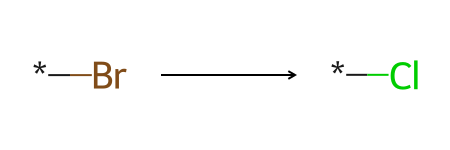

In [77]:
current_idx = 1
mmp_df.rxn_mol.values[current_idx]

Plot the distribution of deltas as a stripplot.

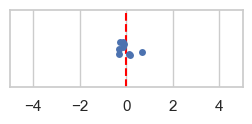

In [78]:
sns.set(rc={'figure.figsize': (3, 1)})
sns.set_style('whitegrid')
ax = sns.stripplot(x=mmp_df.Deltas.values[current_idx])
ax.axvline(0,ls="--",c="red")
ax.set_xlim(-5,5);

We want to create a table showing MMP transforms, and the associated distributions of activity differences (Deltas). To create this table we need to have routines that will generate images and save them as base64 encoded strings that can be displayed in an HTML table. A lot of tricks here were borrowed from an "Is Life Worth Living" blog post. Thanks Pen!

In [79]:
def rxn_to_base64_image(rxn):
    """
    Convert an RDKit reaction to an image
    """
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 150)
    drawer.DrawReaction(rxn)
    drawer.FinishDrawing()
    io.BytesIO()
    text = drawer.GetDrawingText()
    im_text64 = base64.b64encode(text).decode('utf8')
    img_str = f"<img src='data:image/png;base64, {im_text64}'/>"
    return img_str

def strippplot_base64_image(dist):
    """
    Plot a distribution as a seaborn stripplot and save the resulting image as a base64 image. 
    """
    sns.set(rc={'figure.figsize': (3, 1)})
    sns.set_style('whitegrid')
    ax = sns.stripplot(x=dist)
    ax.axvline(0,ls="--",c="red")
    ax.set_xlim(-5,5)
    s = io.BytesIO()
    plt.savefig(s, format='png', bbox_inches="tight")
    plt.close()
    s = base64.b64encode(s.getvalue()).decode("utf-8").replace("\n", "")
    return '<img align="left" src="data:image/png;base64,%s">' % s

Generate the images to go to the HTML table and add them to the mmp_df

In [80]:
mmp_df['MMP Transform'] = mmp_df.rxn_mol.progress_apply(rxn_to_base64_image)
mmp_df['Delta Distribution'] = mmp_df.Deltas.progress_apply(strippplot_base64_image)

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Show a table of MMPs with associated activity distributions. Change rows_to_show below to change the number of rows show in the table. The variable ascending in the table below controls the sort order for the table. If ascending is set to True, MMPs that reduce the hERG IC50 are shown at the top of the table. If we set ascending to False, MMPs that increase hERG activity will be shown at the top. The table shows

    the MMP
    the number of times the MMP occurs in the dataset
    the mean of the difference in pIC50 between molecules containing that MMP
    a stripplot showing the differences

If we look at the first row in the table (index 41 in the far left column), we see that when chlorobenzyl is replaced by benzyl the hERG IC50 is consistently reduced. If we havea molecule with a chlorobenzyl group that has hERG activity, we might think aobut replacing the chlorobenzyl with benzyl.



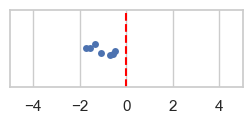
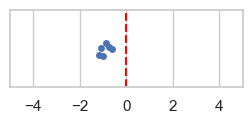
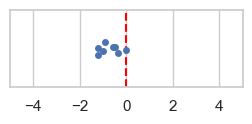
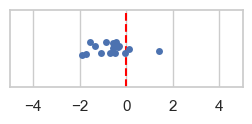
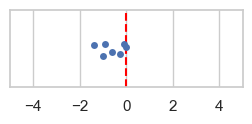
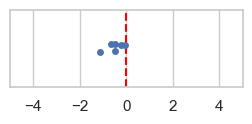
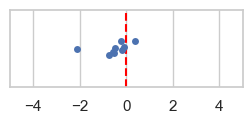
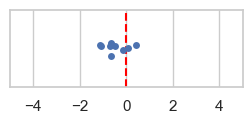
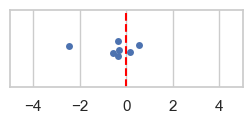
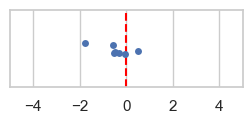

In [81]:
rows_to_show = 10
ascending = True
mmp_df.sort_values("mean_delta",inplace=True,ascending=ascending)
HTML(mmp_df[['MMP Transform','Count',"mean_delta","Delta Distribution"]].round(2).head(rows_to_show).to_html(escape=False))

Once we scan the table above and identify an interesting MMP, we may want to look at all the molecules containing that MMP. To do that, we need to go into delta_df and find the corresponding rows. To make it easy to view the examples with mols2grid, we'll put the MMPs in alternating rows in a new talble. The function below creates a new table with all the rows in delta_df having the the value query_idx in the idx column. The value we use for query_idx is the number in the far left column in the table above. 

In [82]:
def find_examples(delta_df, query_idx):
    example_list = []
    for idx,row in delta_df.query("idx == @query_idx").sort_values("Delta",ascending=False).iterrows():
        smi_1, name_1, pIC50_1 = row.SMILES_1, row.Name_1, row.pIC50_1
        smi_2, name_2, pIC50_2 = row.SMILES_2, row.Name_2, row.pIC50_2
        tmp_list = [(smi_1, name_1, pIC50_1),(smi_2, name_2, pIC50_2)]
        tmp_list.sort(key=itemgetter(0))
        example_list.append(tmp_list[0])
        example_list.append(tmp_list[1])
    example_df = pd.DataFrame(example_list,columns=["SMILES","Name","pIC50"])
    return example_df

Show molecules that include a particular MMP transform. Change the value of query_idx to view molecules containing a particular MMP. Recall that query_idx is the far left column in the fancy table above showing the MMPs. 

In [83]:
query_idx = 84
example_df = find_examples(delta_df, query_idx)
mols2grid.display(example_df,n_cols=4,template='static',prerender=True,size=(200,200),
                 subset=["img","pIC50","Name"],
                 transform={"pIC50": lambda x: f"{x:.2f}"})

MolGridWidget()